# NLP Project - Jonas Luerkens & Esther Kaltwasser

## Setup

In [2]:
# Install requirements
!git clone https://github.com/esthikalt/NLP_Project.git
%cd NLP_Project
!pip install -r requirements.txt


Cloning into 'NLP_Project'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 59 (delta 26), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 5.40 MiB | 4.92 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/NLP_Project


In [24]:
# Import required libraries

from datapreparation import load_and_prepare_data
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorWithPadding, DataCollatorForLanguageModeling, AutoModelForSequenceClassification
import torch
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from datasets import Dataset
import re
from tqdm import tqdm # Loading bar
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Disabling parallelism for tokenizers to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# Load data

train_ds, val_ds, test_ds, label_list, label2id, id2label = load_and_prepare_data()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

aa_dataset-tickets-multi-lang-5-2-50-ver(…):   0%|          | 0.00/26.0M [00:00<?, ?B/s]

(…)set-tickets-german_normalized_50_5_2.csv: 0.00B [00:00, ?B/s]

dataset-tickets-multi-lang-4-20k.csv:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/61765 [00:00<?, ? examples/s]

Filter:   0%|          | 0/61765 [00:00<?, ? examples/s]

Filter:   0%|          | 0/28261 [00:00<?, ? examples/s]

Label distribution (train):
Counter({'Technical Support': 6476, 'Customer Service': 3471, 'Billing and Payments': 2307, 'Sales and Pre-Sales': 655, 'General Inquiry': 340})


In [5]:
# Load the models and tokenizer for task 1 and 2

distilgpt2_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2")

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2") # Same tokenizer as distilgpt2
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
# HIER SET DEVICE
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [7]:
# Metrics can vary across runs due to stochastic training;
# Setting seeds helps ensure that reported results can be replicated
# It fixes the random number generators so the model initializes and trains in the same way each time

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Agent 1: Routing with prompting using GPT-2 (frozen model)

### Prompt function and prompt
Here we define the few-shot prompt for the model. It includes one short, precise example for one email for each department.

In [17]:
# Few-shot learning prompt (1 email per department)

prompt = (
    "Classify the email ONLY into the following categories: Technical Support, Customer Service, Billing and Payments, Sales and Pre-Sales, General Inquiry.\n\n"
    "Subject: Return item | Body: I want to send this product back. -> Department: Customer Service\n"
    "Subject: Invoice missing | Body: I need my bill for July. -> Department: Billing and Payments\n"
    "Subject: Discount inquiry | Body: Do you have bulk pricing? -> Department: Sales and Pre-Sales\n"
    "Subject: Opening hours | Body: When are you open? -> Department: General Inquiry\n"
    "Subject: Internet down | Body: My router is not working. -> Department: Technical Support\n"
)

Now we define the a function that gets an email subject and body and builds the prompt by adding the email content after the few-shot example prompt.

In [18]:
# Prompt building function

def build_prompt(subject: str, body: str) -> str:
    few_shot = prompt

    return (
        few_shot
        + "Subject: " + (subject or "") + " | "
        + "Body: " + (body or "") + " -> "
        + "Department:"
    )

### Email Routing Function
Next, we define the email routing function that gets the model it should use for routing and the email it should route. It builds the prompt using the build_prompt function to build the prompt, tokenizes it and then lets the model generate the output. Afterwards, it only extracts the corresponding department from the output and returns that.

In [19]:
# Email routing function, takes an email dict and returns the predicted department

def route_email(model, dict_email):

    if dict_email is None:
        raise ValueError("Email is None")

    # Cut the email subject and body to a reasonable length

    subject = (dict_email.get("subject") or "")[:200]
    body = (dict_email.get("body") or "")[:1200]

    # Build the prompt consisting of the few-shoot examples and the email that should be routed

    prompt = build_prompt(subject, body)

    # Tokenize the prompt

    inputs = tokenizer_gpt(prompt, return_tensors="pt")

    # Move inputs to same device as output

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=5, # Generate at most 5 tokens
            do_sample=False, # Determenistic decoding, no sampling
            num_beams=3, # Use beam search with 3 beams to explore multiple best continuations
            eos_token_id=tokenizer_gpt.eos_token_id,
            pad_token_id=tokenizer_gpt.eos_token_id, # TODO
        )

    # Generate output

    gen = tokenizer_gpt.decode(
        out[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    ).strip()

    # Postprocess the output to extract the department

    if "Department:" in gen:
        gen = gen.split("Department:", 1)[1].strip()

    ALLOWED = [
        "Technical Support",
        "Customer Service",
        "Billing and Payments",
        "Sales and Pre-Sales",
        "General Inquiry",
    ]
    for d in ALLOWED:
        if gen.startswith(d):
            return d

    # Default to General Inquiry if no valid department found in the generated output
    return "General Inquiry"


### Evaluation Function
The evaluation function runs through the whole test set and routes each email. During the runthrough it creates a confusion matrix from which it can also calculated the accuracy and F1 macro value

In [20]:
def evaluate_model(model):

  LABELS = [
      "Technical Support",
      "Sales and Pre-Sales",
      "Billing and Payments",
      "Customer Service",
      "General Inquiry",
  ]

  label_to_idx = {l: i for i, l in enumerate(LABELS)}
  n = len(LABELS)

  confusion = np.zeros((n, n), dtype=int)

  # Route every email in the test dataset and update the confusion matrix
  for email in test_ds:
      y_true = label_to_idx[email["queue"]]
      y_pred = label_to_idx[route_email(model, email)]
      confusion[y_true, y_pred] += 1

  # Compute the accuracy
  accuracy = np.trace(confusion) / confusion.sum()

  # Compute the Macro F1 score
  eps = 1e-12
  f1s = []

  for i in range(n):
      tp = confusion[i, i]
      fp = confusion[:, i].sum() - tp
      fn = confusion[i, :].sum() - tp

      precision = tp / (tp + fp + eps)
      recall = tp / (tp + fn + eps)
      f1s.append(2 * precision * recall / (precision + recall + eps))

  macro_f1 = float(np.mean(f1s))

  # Put out the accuracy, macro F1 and the confusion matrix as a heatmap
  print(f"Accuracy:  {accuracy:.2%}")
  print(f"Macro F1:  {macro_f1:.3f}")

  plt.figure(figsize=(6, 5))
  sns.heatmap(
      confusion,
      annot=True,
      fmt="d",
      cmap="Blues",
      xticklabels=LABELS,
      yticklabels=LABELS,
  )

  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.show()


### Evaluation
Here we call the previously defined evaluation function on both models to compute the performance results for the first task

In [21]:
evaluate_model(distilgpt2_model)
evaluate_model(gpt2_model)


KeyboardInterrupt: 

## Agent 2: Routing with fine-tuning (LoRA) on GPT-2 and DistilGPT2

### LoRa configuration
Here we determine the configurations for the LoRA

In [8]:
# Configure the Lora

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8, # Rank of the LoRA update matrices (higher = more capacity, more trainable params)
    lora_alpha=16,# Scaling factor for LoRA updates (controls how strongly LoRA affects the base weights)
    lora_dropout=0.05, # Dropout applied to LoRA layers during training (helps reduce overfitting)
    target_modules=["c_attn", "c_proj"],  # Apply LoRA only to these GPT-2 attention/projection layers
    bias="none", # Do not train/add bias parameters (keeps the number of trainable params smaller)
)


### Model initialization function
This function initiates the model for training. It gets a model name and first loads the pretrained model and sets the pad/eos token IDs to match the tokenizer to avoid token-mismatch issues during batching and loss computation Then it wrap the model with PEFT LoRA adapters and sets it to training mode. The model is the returned

In [9]:
def initiate_model_for_training(model_name):

  model = AutoModelForCausalLM.from_pretrained(model_name)

  model.config.pad_token_id = tokenizer_gpt.pad_token_id
  model.config.eos_token_id = tokenizer_gpt.eos_token_id

  model = get_peft_model(model, lora_config)

  model.train()

  return model

### Data preprocessing functions
The tokenize function formats each email into a prompt–target pair, tokenizes both parts, truncates to a fixed maximum length (256 tokens), and masks the prompt tokens in the labels so that the model is trained to predict only the classification label in a causal language modeling setup.


In [10]:
def tokenize(email):

    # Truncate subject and body to limit extremely long inputs
    # (helps control total sequence length and memory usage)
    subject = str(email["subject"])[:200]
    body = str(email["body"])[:1200]
    label = str(email["label"]).strip()

    # Build the prompt
    prompt = build_prompt(subject, body)

    # The target is the gold label followed by EOS token.
    # Leading space ensures proper tokenization for GPT-style models.
    target = " " + label + tokenizer_gpt.eos_token

    # Tokenize prompt and target separately without adding extra special tokens
    # (we control EOS manually)
    prompt_ids = tokenizer_gpt(prompt, add_special_tokens=False)["input_ids"]
    target_ids = tokenizer_gpt(target, add_special_tokens=False)["input_ids"]

    # Ensure total length does not exceed model limit (256 tokens here)
    # We reserve space for the target and truncate the prompt if needed
    max_prompt_len = 256 - len(target_ids)

    if max_prompt_len < 1:
        # If the target itself exceeds max length,
        # truncate the target and discard the prompt
        target_ids = target_ids[:256]
        prompt_ids = []
    else:
        # Otherwise truncate the prompt to fit within max length
        prompt_ids = prompt_ids[:max_prompt_len]

    # Final input is prompt followed by target (standard causal LM setup)
    input_ids = prompt_ids + target_ids

    # Attention mask: 1 for real tokens (no padding used here)
    attention_mask = [1] * len(input_ids)

    # Labels:
    # - Ignore prompt tokens in the loss by setting them to -100
    # - Compute loss only on target tokens (the label)
    labels = [-100] * len(prompt_ids) + target_ids

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


The preprocessing function gets a dataset and first standardizes the dataset by renaming the queue column to label. It then removes all unnecessary columns and tokenizes the data into model-ready inputs (input IDs, attention masks, and labels) for causal language model training. Then it returns the ready dataset

In [11]:
# Renaming function

def rename_queue_to_label(ex):
    lab = ex["queue"]
    if lab is None:
        lab = ""
    return {"label": str(lab).strip()}

# Preprocessing function

def preprocess_for_training(dataset):

  keep_cols = ["subject", "body", "queue"]
  dataset = dataset.remove_columns([c for c in dataset.column_names if c not in keep_cols])
  dataset = dataset.map(rename_queue_to_label)
  dataset = dataset.remove_columns(['queue'])
  tokenized_dataset = dataset.map(tokenize, remove_columns=dataset.column_names)

  return tokenized_dataset

### Training configuration
We configure the training arguments here. We used a per-device batch size of 2 with gradient accumulation over 8 steps (effective batch size = 16). The model was trained for 10 epochs with a learning rate of 3e-4. Evaluation and checkpointing were conducted at the end of each epoch, and up to 10 checkpoints were retained.

In [12]:
# Set the training arguments
def make_training_args(model_name):
    output_path = f"{model_name}_fine-tuned"

    args = TrainingArguments(
        output_dir= output_path, # Directory to save checkpoints and logs
        per_device_train_batch_size=2, # Batch size per GPU/CPU device
        gradient_accumulation_steps=8,  # Accumulate gradients to simulate a larger batch (effective batch = 2*8 = 16)
        num_train_epochs=10,
        learning_rate=3e-4,

        save_strategy="epoch",
        eval_strategy="epoch",
        save_total_limit=10,
        report_to="none"
    )

    return args

### Batching function
The collate_fn dynamically pads all sequences in a batch to the length of the longest example in that batch and converts them into PyTorch tensors. Padding tokens are masked in both the attention mask (0) and the loss computation (-100 in labels).


In [13]:
# Custom collate function for dynamic padding within each batch
def collate_fn(batch):
    pad_id = tokenizer_gpt.pad_token_id

    # Determine the maximum sequence length in the current batch
    max_len = max(len(x["input_ids"]) for x in batch)

    input_ids, attention_mask, labels = [], [], []

    for x in batch:
        ids, att, lab = x["input_ids"], x["attention_mask"], x["labels"]

        # Compute how much padding is needed for this example
        pad_len = max_len - len(ids)

        # Pad input_ids with pad token ID
        input_ids.append(ids + [pad_id] * pad_len)

        # Pad attention_mask with 0 (0 = ignore padding tokens)
        attention_mask.append(att + [0] * pad_len)

        # Pad labels with -100 so padding tokens are ignored in loss computation
        labels.append(lab + [-100] * pad_len)

    # Convert lists into PyTorch tensors for model input
    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
    }


### Trainer initialization function

In [15]:
def initialize_trainer(model, train_dataset, eval_dataset, args):

  trainer = Trainer(
      model=model,
      args=args,
      train_dataset=train_dataset,
      eval_dataset=eval_dataset,
      data_collator=collate_fn
  )
  return trainer


### Training

In [16]:
# Initialize models

model_for_training_distilgpt2 = initiate_model_for_training("distilgpt2")
model_for_training_gpt2 = initiate_model_for_training("gpt2")

# Preprocess and tokenize datasets
tokenized_train = preprocess_for_training(train_ds)
tokenized_val = preprocess_for_training(val_ds)

# Make training arguments
training_args_gpt2 = make_training_args("gpt2")
training_args_distilgpt2 = make_training_args("distilgpt2")

# Initialize trainer

trainer_gpt2 = initialize_trainer(model_for_training_gpt2, tokenized_train, tokenized_val, training_args_gpt2)
trainer_distilgpt2 = initialize_trainer(model_for_training_distilgpt2, tokenized_train, tokenized_val, training_args_distilgpt2)

# Train models

#trainer_gpt2.train()
#model_fine_tuned_gpt2 = trainer_gpt2.model
#trainer_gpt2.save_model("gpt2_fine-tuned")

#trainer_distilgpt2.train()
#trainer_distilgpt2.save_model("distilgpt2_fine-tuned")
#model_fine_tuned_distilgpt2 = trainer_distilgpt2.model


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:78: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'distilgpt2' to 'gpt2'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


Map:   0%|          | 0/13249 [00:00<?, ? examples/s]

Map:   0%|          | 0/13249 [00:00<?, ? examples/s]

NameError: name 'build_prompt' is not defined

### Load trained models from directory

In [ ]:
#model_fine_tuned_gpt2 = PeftModel.from_pretrained(gpt2_model, 'gpt2_fine-tuned')
#model_fine_tuned_gpt2.eval()


#model_fine_tuned_distilgpt2 = PeftModel.from_pretrained(distilgpt2_model, 'distilgpt2_fine-tuned')
#model_fine_tuned_distilgpt2.eval()

### Evaluation

In [ ]:
#evaluate_model(model_fine_tuned_gpt2)
#evaluate_model(model_fine_tuned_distilgpt2)

## Agent 3: Routing with discriminative classifier using a BERT-like model

### Training:

In [ ]:
# Task 3: BERT Fine-Tuning

# Setup
bert_checkpoint = "distilbert-base-uncased"
output_dir = "./distilbert-checkpoint"

# Loading tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint)

# Preprocessing function
def preprocess_bert(examples):
    # Making sure all inputs are strings
    subjects = [str(s) if s is not None else "" for s in examples["subject"]]
    bodies = [str(b) if b is not None else "" for b in examples["body"]]

    # Tokenization
    return bert_tokenizer(
        subjects,
        bodies,
        truncation=True,
        padding="max_length",
        max_length=256
    )

print("Tokenizing datasets.")
encoded_train = train_ds.map(preprocess_bert, batched=True)
encoded_val = val_ds.map(preprocess_bert, batched=True)
encoded_test = test_ds.map(preprocess_bert, batched=True)

# Label Formatting
def format_labels(example):
    return {"label": label2id[example["queue"]]}

# Label mapping
bert_train_ds = encoded_train.map(format_labels)
bert_val_ds = encoded_val.map(format_labels)
bert_test_ds = encoded_test.map(format_labels)

# Set columns
cols_to_keep = ["input_ids", "attention_mask", "label"]
bert_train_ds.set_format(type="torch", columns=cols_to_keep)
bert_val_ds.set_format(type="torch", columns=cols_to_keep)
bert_test_ds.set_format(type="torch", columns=cols_to_keep)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Loading model
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_checkpoint,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
).to(device)

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

# Training Arguments
bert_args = TrainingArguments(
    output_dir=output_dir,

    learning_rate=3e-5,
    num_train_epochs=4, # 10 was overfitting
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    warmup_ratio=0.1,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    logging_steps=50,
    report_to="none"
)

# 7. Trainer
bert_trainer = Trainer(
    model=bert_model,
    args=bert_args,
    train_dataset=bert_train_ds,
    eval_dataset=bert_val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# print("Starting Training DistilBERT:")
# bert_trainer.train()

# # Saving the model
# save_path = "./distilbert-path"

# bert_trainer.save_model(save_path)
# bert_tokenizer.save_pretrained(save_path)

# print("Model saved!")

Tokenizing datasets.


Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


### Saving:

In [ ]:
# Loading the BERT model
model_bert_path = "./distilbert-final-overfitted"

# Initialize model and tokenizer
model_bert = AutoModelForSequenceClassification.from_pretrained(model_bert_path) # AutoModelForSequenceClassification because it's a classifier
tokenize_bert = AutoTokenizer.from_pretrained(model_bert_path)

model_bert.to(device)
model_bert.eval()

print("Model loaded!")

### Evaluation function:

In [ ]:
# Evaluation Function for DistilBERT
def evaluate_bert_model(model, tokenizer, dataset, name="DistilBERT"):
    # Evaluation (Accuracy, Macro-F1, Macro-Recall, Confusion Matrix)
    print(f"Evaluating {name}:")

    # Evaluation Trainer Setup
    eval_trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=TrainingArguments(
            output_dir="./eval_results",
            report_to="none",
            per_device_eval_batch_size=16
        )
    )

    # Generating predictions
    output = eval_trainer.predict(dataset)

    # Getting predicted and true labels
    y_pred = np.argmax(output.predictions, axis=1)
    y_true = output.label_ids

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    # Labels
    ALLOWED_CLASSES = [
        "Technical Support",
        "Sales and Pre-Sales",
        "Billing and Payments",
        "Customer Service",
        "General Inquiry"
    ]

    # Label IDs
    label2id = model.config.label2id
    custom_ids = [label2id[lab] for lab in ALLOWED_CLASSES]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=custom_ids)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ALLOWED_CLASSES)
    disp.plot(cmap="Blues", ax=ax, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - {name}\n(Acc: {acc:.1%} | F1: {f1:.1%} | Recall: {recall:.1%})")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{name}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Output metrics
    return {"accuracy": acc, "f1": f1, "recall": recall}

### Evaluation:

In [ ]:
# Evaluation of DistilBERT
_ = evaluate_bert_model(model_bert, tokenize_bert, bert_test_ds, name="DistilBERT")

Evaluation Results:

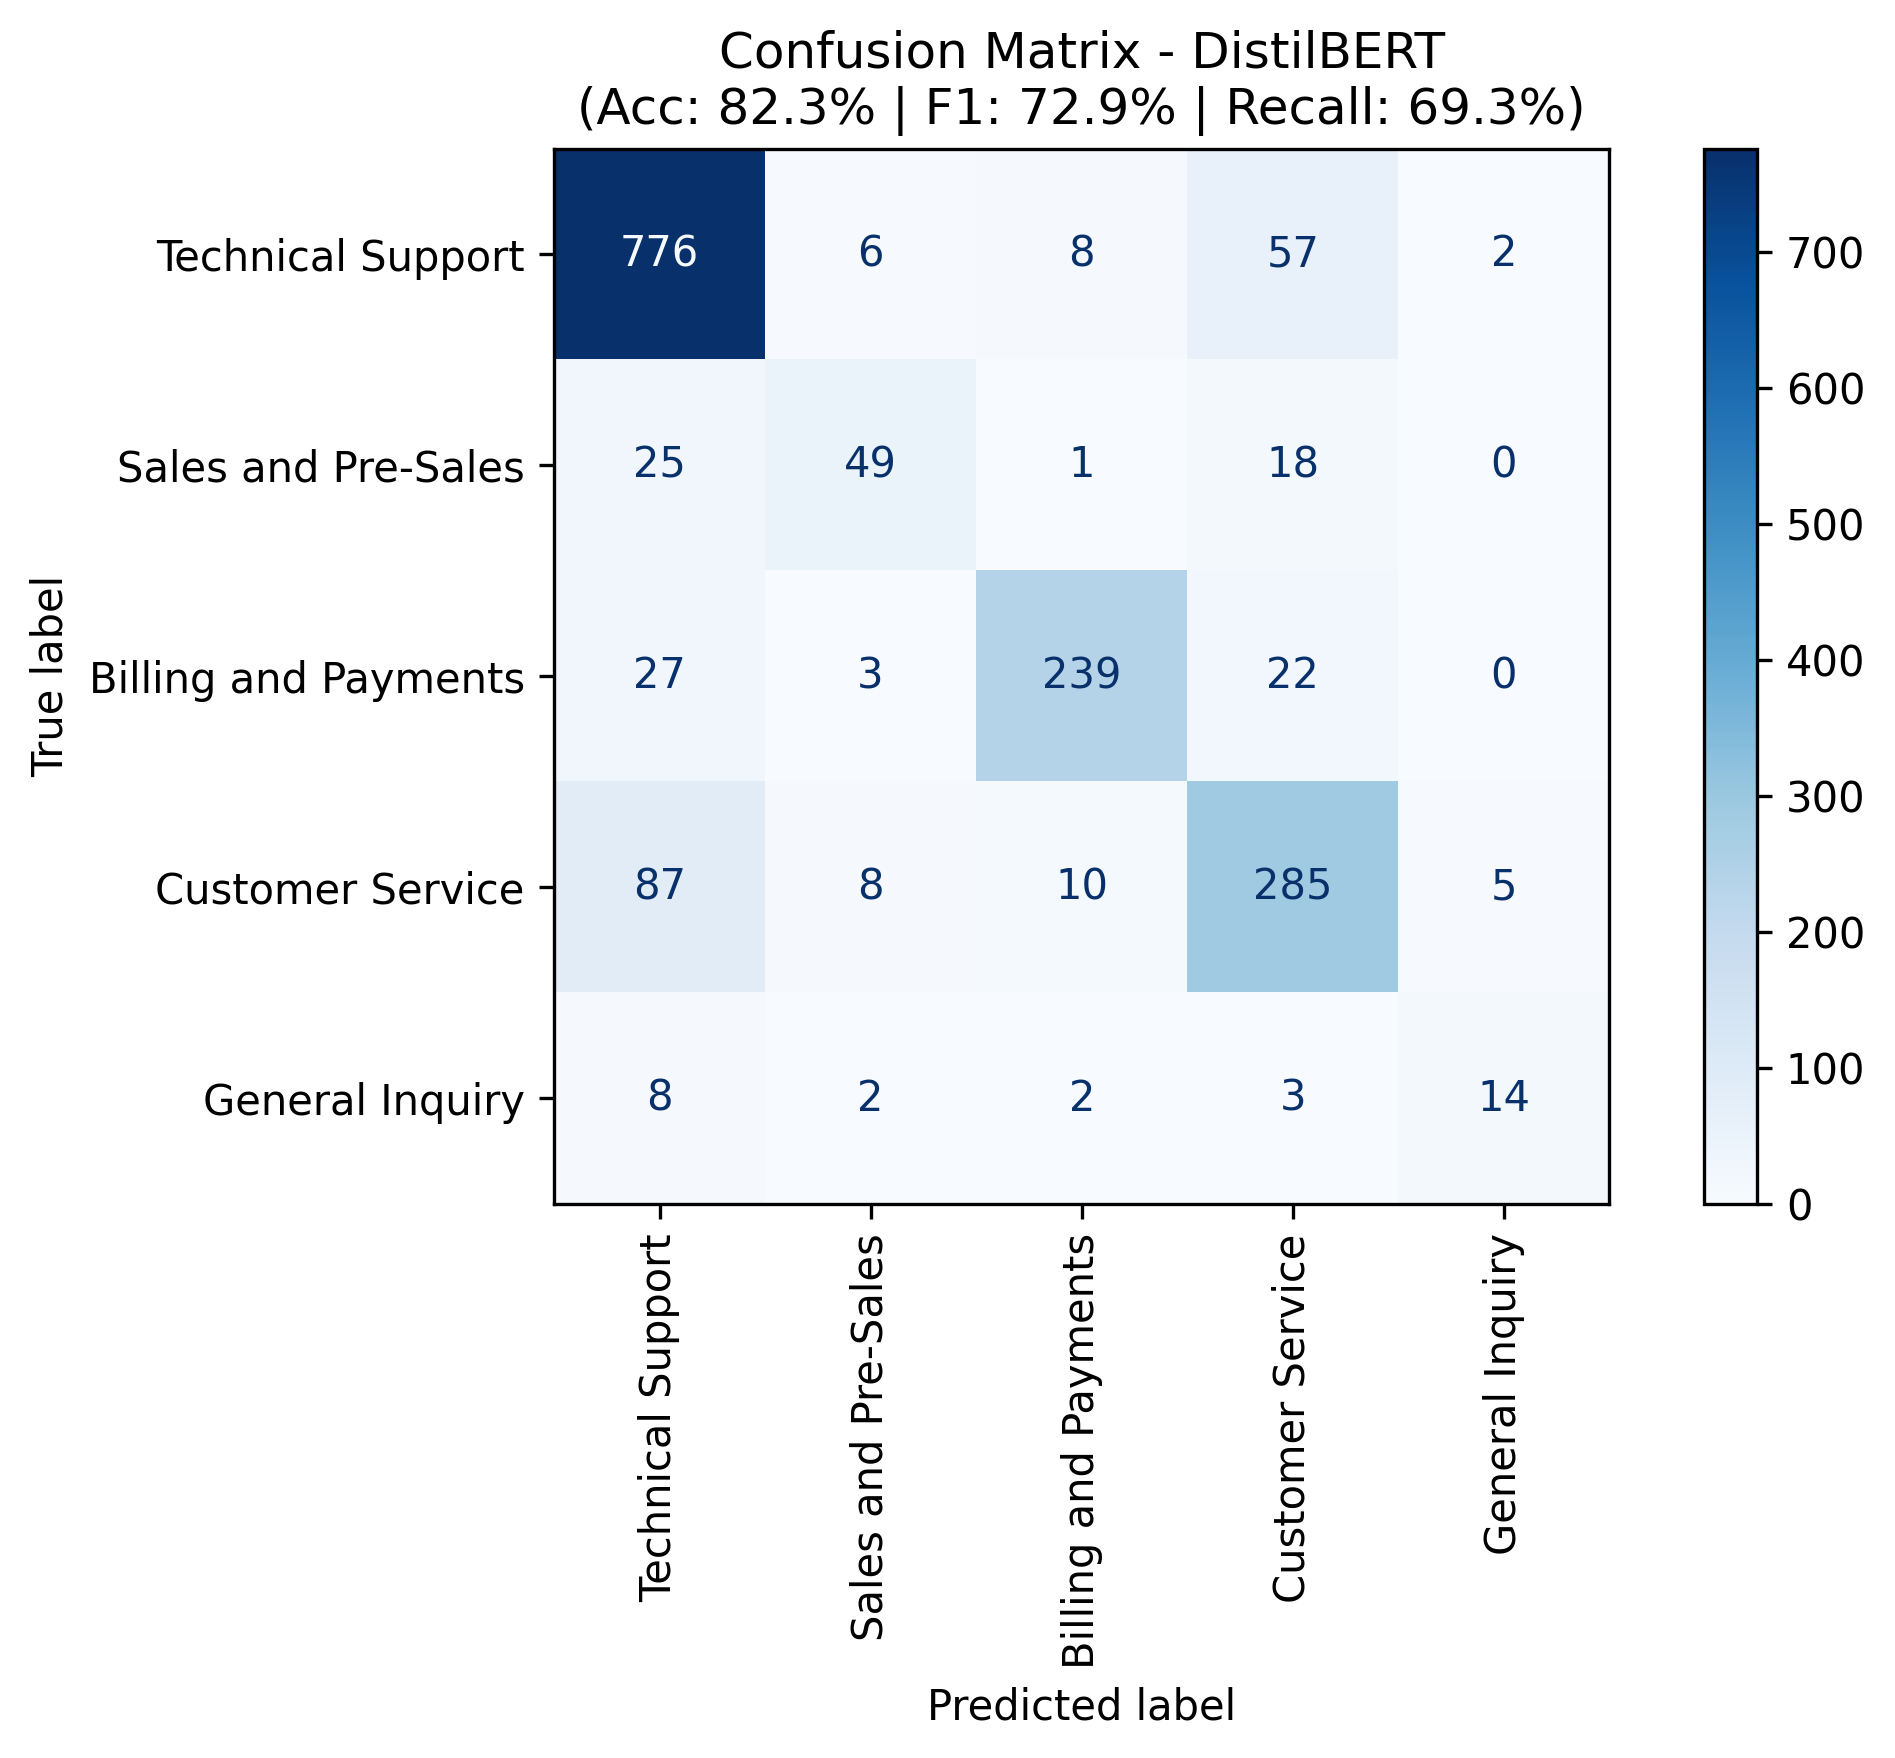

In [26]:
# Display Results
display(Image(filename="confusion_matrix_DistilBERT.png", width=600))